In [1]:
# import necessary functions
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [10]:
from statesim.model.statespace import Linear, Nonlinear, Lure
from statesim.simulator import DiscreteSimulator, ContinuousSimulator
from statesim.system.coupled_msd import CoupledMsd
from statesim.generate.input import random_static_input
from statesim.noise import NoiseGeneration
from statesim.configuration import InputGeneratorConfig
from statesim.analysis import plot_simulation_results as plot
import os
import matplotlib.pyplot as plt

from deepsysid.pipeline.configuration import ExperimentModelConfiguration
from deepsysid.models.recurrent.constrained_rnn import (
    HybridConstrainedRnnConfig,
)
import json

import numpy as np
import copy
import pandas as pd

In [11]:
step_size = 0.2

In [12]:
# load caligraphic matrices from csv file
model_dir = os.path.expanduser('~/coupled-msd/models_local')

config_file_path = os.path.join(
    model_dir,
    'HybridCRnn-10-8000000-False/config-HybridCRnn-10-8000000-False.json',
)
cal_block_matrix_file_path = os.path.join(
    model_dir,
    'HybridCRnn-10-8000000-False/HybridCRnn-10-8000000-False.cal_block_matrix.csv',
)
omega_file_path = os.path.join(
    model_dir,
    'HybridCRnn-10-8000000-False/HybridCRnn-10-8000000-False.omega.csv',
)

omega = np.array(pd.read_csv(omega_file_path, header=None))
cal_block_matrix = np.array(
    pd.read_csv(cal_block_matrix_file_path, header=None)
)
print(omega.shape)
print(cal_block_matrix.shape)

with open(config_file_path, 'r') as f:
    config_dict = json.load(f)
hybird_model_config = HybridConstrainedRnnConfig.parse_obj(
    config_dict['parameters']
)

lin_sys = Linear(
    np.array(hybird_model_config.A_lin),
    np.array(hybird_model_config.B_lin),
    np.array(hybird_model_config.C_lin),
    np.array([[0]]),
)
T = 50
N = int(T / step_size)
sim = DiscreteSimulator(T, step_size)

wp = random_static_input(
    N,
    1,
    InputGeneratorConfig(
        type='random_static_input',
        u_min=-1.5,
        u_max=1.5,
        interval_min=80,
        interval_max=120,
    ),
)

lin_res = sim.simulate(lin_sys, np.zeros(shape=(8, 1)), wp, 'lin')

x_mean = np.mean(np.hstack(lin_res.xs), axis=1).reshape(-1, 1)
x_std = np.std(np.hstack(lin_res.xs), axis=1).reshape(-1, 1)
wp_mean = np.mean(np.hstack(wp), axis=1).reshape(-1, 1)
wp_std = np.std(np.hstack(wp), axis=1).reshape(-1, 1)

# plot.plot_outputs(lin_res)
n_xlin = len(hybird_model_config.A_lin)
n_xrnn = (
    hybird_model_config.nwu if hybird_model_config.extend_state else n_xlin
)
n_u = n_xlin
n_wp = len(hybird_model_config.control_names)
n_zp = len(hybird_model_config.state_names)
n_wu = hybird_model_config.nwu


e = n_xrnn - n_xlin
if e > 0:
    y = np.hstack(
        [np.vstack((y_k, np.zeros(shape=(e, 1)))) for y_k in lin_res.xs]
    )
    # y = np.zeros(shape=(n_xrnn, N))
else:
    y = np.hstack(lin_res.xs)
    # y = np.zeros(shape=(n_xrnn, N))
wp_np = np.hstack(wp)
# wp_np = np.zeros(shape=(n_wp, N))
wp_ys = [wp_y_k.reshape(-1, 1) for wp_y_k in np.vstack((wp_np, y)).T]

alpha = 0
beta = 1
if hybird_model_config.nonlinearity == 'Tanh':
    nl = np.tanh
elif hybird_model_config.nonlinearity == 'ReLU':
    nl = lambda x: np.maximum(0, x)
Delta_tilde = lambda z: (2 / (beta - alpha)) * (
    nl(z) - ((alpha + beta) / 2) * z
)
Delta = nl

# plot.plot_outputs(lure_res)

(26, 27)
(27, 36)


normalized input, mean: [ 1.70530257e-16 -2.27373675e-16  2.77111667e-16  0.00000000e+00
 -2.27373675e-16 -3.97903932e-16  1.70530257e-16 -2.27373675e-16
  0.00000000e+00], std: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

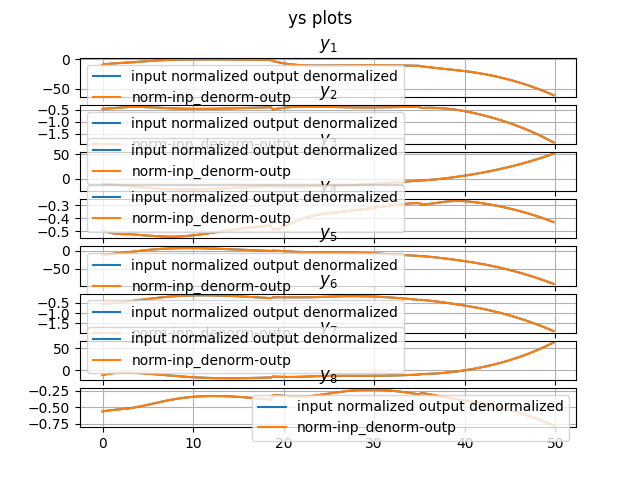

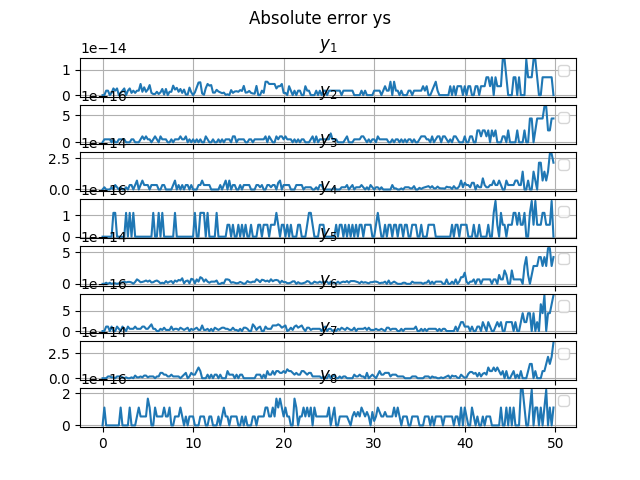

In [160]:
A = omega[:n_xrnn, :n_xrnn]
B1 = omega[:n_xrnn, n_xrnn : n_xrnn + n_wp]
B2 = omega[:n_xrnn, n_xrnn + n_wp : n_xrnn + n_wp + n_xrnn]
B3 = omega[:n_xrnn, n_xrnn + n_wp + n_xrnn :]

B1_hat = np.hstack(
    (
        B1 @ np.diag(np.squeeze(1 / wp_std, 1)),
        B2 @ np.diag(np.squeeze(1 / x_std, 1)),
        -(B1 @ np.diag(np.squeeze(1 / wp_std, 1))),
        -(B2 @ np.diag(np.squeeze(1 / x_std, 1))),
    )
)

C1 = omega[n_xrnn : n_xrnn + n_xrnn, :n_xrnn]
D11 = omega[n_xrnn : n_xrnn + n_xrnn, n_xrnn : n_xrnn + n_wp]
D12 = omega[n_xrnn : n_xrnn + n_xrnn, n_xrnn + n_wp : n_xrnn + n_wp + n_xrnn]
D13 = omega[n_xrnn : n_xrnn + n_xrnn, n_xrnn + n_wp + n_xrnn :]

D11_hat = np.hstack(
    (
        np.diag(np.squeeze(x_std, 1))
        @ D11
        @ np.diag(np.squeeze(1 / wp_std, 1)),
        np.diag(np.squeeze(x_std, 1))
        @ D12
        @ np.diag(np.squeeze(1 / x_std, 1)),
        -(
            np.diag(np.squeeze(x_std, 1))
            @ D11
            @ np.diag(np.squeeze(1 / wp_std, 1))
        ),
        -(
            np.diag(np.squeeze(x_std, 1))
            @ D12
            @ np.diag(np.squeeze(1 / x_std, 1))
        )
        + np.eye(n_u),
    )
)

C2 = omega[n_xrnn + n_xrnn :, :n_xrnn]
D21 = omega[n_xrnn + n_xrnn :, n_xrnn : n_xrnn + n_wp]
D22 = omega[n_xrnn + n_xrnn :, n_xrnn + n_wp : n_xrnn + n_wp + n_xrnn]
D23 = omega[n_xrnn + n_xrnn :, n_xrnn + n_wp + n_xrnn :]

D21_hat = np.hstack(
    (
        D21 @ np.diag(np.squeeze(1 / wp_std, 1)),
        D22 @ np.diag(np.squeeze(1 / x_std, 1)),
        -(D21 @ np.diag(np.squeeze(1 / wp_std, 1))),
        -(D22 @ np.diag(np.squeeze(1 / x_std, 1))),
    )
)

lure_sys_norm = Lure(
    A,
    B1_hat,
    B3,
    np.diag(np.squeeze(x_std, 1)) @ C1,
    C2,
    D11_hat,
    np.diag(np.squeeze(x_std, 1)) @ D13,
    D21_hat,
    Delta,
)
wp_y_wp_n_y_ns = [
    np.vstack((wp_y, wp_mean, x_mean)).reshape(-1, 1) for wp_y in wp_ys
]
lure_res_norm = sim.simulate(
    lure_sys_norm,
    np.zeros(shape=(n_xrnn, 1)),
    wp_y_wp_n_y_ns,
    'norm-inp_denorm-outp',
)

norm_input = np.hstack(
    [lure_sys_norm.B @ wp_y_wp_n_y_n for wp_y_wp_n_y_n in wp_y_wp_n_y_ns]
)


lure_sys = Lure(
    A,
    np.hstack((B1, B2)),
    B3,
    C1,
    C2,
    np.hstack((D11, D12)),
    D13,
    np.hstack((D21, D22)),
    Delta,
)
wp_ys_norm = [
    wp_y_k.reshape(-1, 1)
    for wp_y_k in np.vstack(
        ((wp_np - wp_mean) / wp_std, (y - x_mean) / x_std)
    ).T
]

inp_seq = np.hstack([wp_y for wp_y in wp_ys_norm])
print(
    f'normalized input, mean: {np.mean(inp_seq, axis=1)}, std: {np.std(inp_seq, axis=1)}'
)


lure_res_inp_norm = sim.simulate(
    lure_sys, np.zeros(shape=(n_xrnn, 1)), wp_ys_norm, 'input normalized'
)
lure_res_inp_norm.name = 'input normalized output denormalized'
lure_res_inp_norm.ys = [u_n * x_std + x_mean for u_n in lure_res_inp_norm.ys]

plot.plot_comparison([lure_res_inp_norm, lure_res_norm], 'ys')

In [58]:
A_cal = cal_block_matrix[: n_xrnn + n_xrnn, : n_xrnn + n_xrnn]
# print(np.round(A_cal,2))
# print(np.max(np.abs(np.linalg.eig(A)[0])))
B1_cal = cal_block_matrix[
    : n_xrnn + n_xrnn, n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_wp
]
B2_cal = cal_block_matrix[
    : n_xrnn + n_xrnn, n_xrnn + n_xrnn + n_wp : n_xrnn + n_xrnn + n_wp + n_wu
]

C1_cal = cal_block_matrix[
    n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_zp, : n_xrnn + n_xrnn
]
D11_cal = cal_block_matrix[
    n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_zp,
    n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_wp,
]
D12_cal = cal_block_matrix[
    n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_zp,
    n_xrnn + n_xrnn + n_wp : n_xrnn + n_xrnn + n_wp + n_wu,
]

C2_cal = cal_block_matrix[n_xrnn + n_xrnn + n_zp :, : n_xrnn + n_xrnn]
D21_cal = cal_block_matrix[
    n_xrnn + n_xrnn + n_zp :, n_xrnn + n_xrnn : n_xrnn + n_xrnn + n_wp
]
D22_cal = cal_block_matrix[
    n_xrnn + n_xrnn + n_zp :,
    n_xrnn + n_xrnn + n_wp : n_xrnn + n_xrnn + n_wp + n_wu,
]

lure_sys = Lure(
    A_cal,
    B1_cal,
    B2_cal,
    C1_cal,
    C2_cal,
    D11_cal,
    D12_cal,
    D21_cal,
    Delta_tilde,
)
lure_res = sim.simulate(
    lure_sys, np.zeros(shape=(n_xrnn + n_xrnn, 1)), wp, 'lure'
)
# plot.plot_outputs(lure_res)

msd = CoupledMsd()
nl_model = Nonlinear(
    f=msd.state_dynamics, g=msd.output_function, nx=8, nu=1, ny=1
)

# plt.clf()
# plt.plot(np.linspace(-5,5,100),Delta_tilde(np.linspace(-5,5,100)))
# plt.show()

# sim_cont = ContinuousSimulator(T, step_size)
# nl_res = sim_cont.simulate(nl_model, np.zeros(shape=(n_xlin,1)),wp,'true')
# plot.plot_comparison([nl_res, lure_res, lin_res], 'ys')